cd OneDrive/Bureaublad/ARC/deep-multimodal-learning/mvae/Scripts/activate.bat

In [1]:
import torch
from functions import get_loader, visualize_reconstruction
from functions_cae import train_cae, validate_cae, CAE, SimpleCAE, SimpleCAE_Dropout, collect_latent_vectors
from sklearn.manifold import TSNE
import torch.nn as nn

In [2]:
# Check if CUDA is available
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU...")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU...")

##### CONFIG
NUM_EPOCHS = 3
LR_RATE = 1e-3
BATCH_SIZE = 5
WEIGHT_DECAY = 1e-5
lossfunction = nn.BCELoss()

BASE_PATH = 'C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/data_v2'

# Define the tool names and actions
TOOL_NAMES = ['hook', 'ruler', 'spatula', 'sshot']
ACTIONS = ['left_to_right', 'pull', 'push', 'right_to_left']

# All available object names
train_objects = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
            '5_blackCoinbag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg','9_pumpkinToy',
            '10_tomatoCan', '11_boxMilk']

val_objects = ['12_containerNuts', '13_cornCob', '14_yellowFruitToy',
            '15_bottleNailPolisher']

test_objects =['16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

train_loader = get_loader(BASE_PATH, train_objects, TOOL_NAMES, ACTIONS, "color", "training", batch_size=BATCH_SIZE)
val_loader = get_loader(BASE_PATH, val_objects, TOOL_NAMES, ACTIONS, "color", "validation", batch_size=BATCH_SIZE)
test_loader = get_loader(BASE_PATH, test_objects, TOOL_NAMES, ACTIONS, "color", "testing", batch_size=BATCH_SIZE)

# Training loop
model = CAE().to(device)
#model = SimpleCAE().to(device)
#model = SimpleCAE_Dropout().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE, weight_decay=WEIGHT_DECAY)
trained_model = train_cae(model, train_loader, lossfunction, optimizer, NUM_EPOCHS, LR_RATE, device)
validate_cae(trained_model, val_loader, lossfunction, device)

CUDA is available. Using GPU...
Batch Loss: 0.6933
Batch Loss: 0.6931
Batch Loss: 0.6928
Batch Loss: 0.6926
Batch Loss: 0.6924
Batch Loss: 0.6922
Batch Loss: 0.6918
Batch Loss: 0.6903
Batch Loss: 0.6911
Batch Loss: 0.6896
Batch Loss: 0.6904
Batch Loss: 0.6901
Batch Loss: 0.6889
Batch Loss: 0.6852
Batch Loss: 0.6808
Batch Loss: 0.6711
Batch Loss: 0.6581
Batch Loss: 0.6727
Batch Loss: 0.6546
Batch Loss: 0.6592
Batch Loss: 0.6440
Batch Loss: 0.6383
Batch Loss: 0.6459
Batch Loss: 0.6362
Batch Loss: 0.6383
Batch Loss: 0.6359
Batch Loss: 0.6364
Batch Loss: 0.6364
Batch Loss: 0.6336
Batch Loss: 0.6317
Batch Loss: 0.6294
Batch Loss: 0.6313
Batch Loss: 0.6316
Batch Loss: 0.6279
Batch Loss: 0.6305
Batch Loss: 0.6349
Batch Loss: 0.6327
Batch Loss: 0.6297
Batch Loss: 0.6317
Batch Loss: 0.6271
Batch Loss: 0.6283
Batch Loss: 0.6326
Batch Loss: 0.6280
Batch Loss: 0.6311
Batch Loss: 0.6284
Batch Loss: 0.6280
Batch Loss: 0.6293
Batch Loss: 0.6265
Batch Loss: 0.6251
Batch Loss: 0.6290
Batch Loss: 0.6269

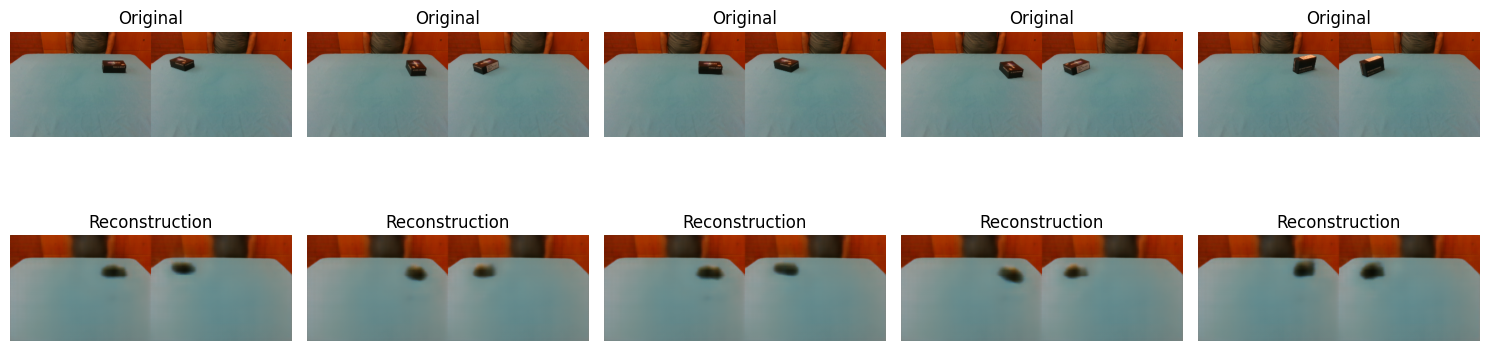

In [3]:
visualize_reconstruction(trained_model, test_loader, num_samples=5)

In [4]:
latent_vectors = collect_latent_vectors(trained_model, test_loader)
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

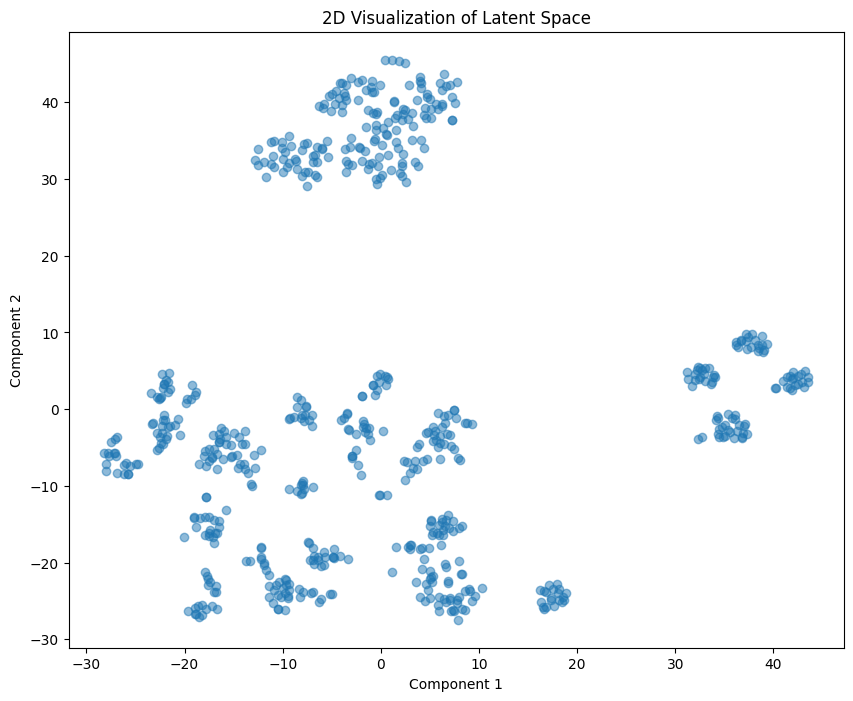

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D Visualization of Latent Space')
plt.show()

In [6]:
from sklearn.manifold import TSNE

latent_vectors = collect_latent_vectors(trained_model, test_loader)
tsne = TSNE(n_components=3, random_state=42)
latent_3d = tsne.fit_transform(latent_vectors)

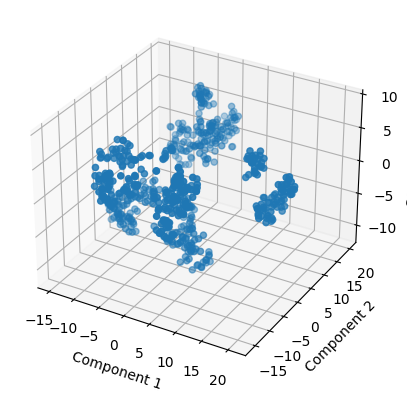

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2])

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()